In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from glob import glob
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

1. 通道2高频操作：635次操作远高于其他通道，可能是设备故障或误触发
2. 通道3调光异常：108次亮度=90的操作中，86%集中在08:24-09:15时段，呈周期性出现
3. 响应时间：99.3%的操作在24ms内完成，符合正常要求（1次25ms可能是偶发）

In [20]:
filename = '2025_06_26'

df = pd.read_csv(f"../datas/LightControlCheck/{filename}.csv")

df['亮度'] = df['亮度'].astype(int)
df['设置时间'] = df['设置时间'].str[:-2].astype(int)
df['时间'] = pd.to_datetime(df['时间'], format='%Y/%m/%d %H:%M:%S:%f')

In [21]:
# 分析1: 通道操作频率
channel_counts = df['通道'].value_counts().sort_index()
print("=== 通道操作频率 ===")
channel_counts

=== 通道操作频率 ===


通道
1     516
2    2858
3    2516
4    2064
5    1032
6    1032
Name: count, dtype: int64

In [22]:
# 分析2: 异常调光操作
abnormal_brightness = df[df['亮度'].between(1, 254)]
if not abnormal_brightness.empty:
    print("\n=== 异常调光操作 ===")
    print(abnormal_brightness.groupby('通道')['亮度'].value_counts())


=== 异常调光操作 ===
通道  亮度
2   60     22
3   90    258
Name: count, dtype: int64


In [23]:
# 分析3: 响应时间分析
print("\n=== 响应时间分析 ===")
print(f"平均响应时间: {df['设置时间'].mean():.2f}ms")
print(f"最大响应时间: {df['设置时间'].max()}ms")
print(f"响应时间>24ms记录: {len(df[df['设置时间'] > 24])} / {len(df)}条")


=== 响应时间分析 ===
平均响应时间: 23.56ms
最大响应时间: 26ms
响应时间>24ms记录: 375 / 10018条


In [24]:
# 分析4: 时间分布模式
df['小时分钟'] = df['时间'].dt.strftime('%H:%M')
time_dist = df['小时分钟'].value_counts().sort_index()
print("\n=== 操作时间分布 ===")
time_dist


=== 操作时间分布 ===


小时分钟
08:21    30
08:22    66
08:23    78
08:24    12
08:50    32
         ..
19:26    38
19:28    40
19:30    38
19:31    40
19:34    38
Name: count, Length: 280, dtype: int64

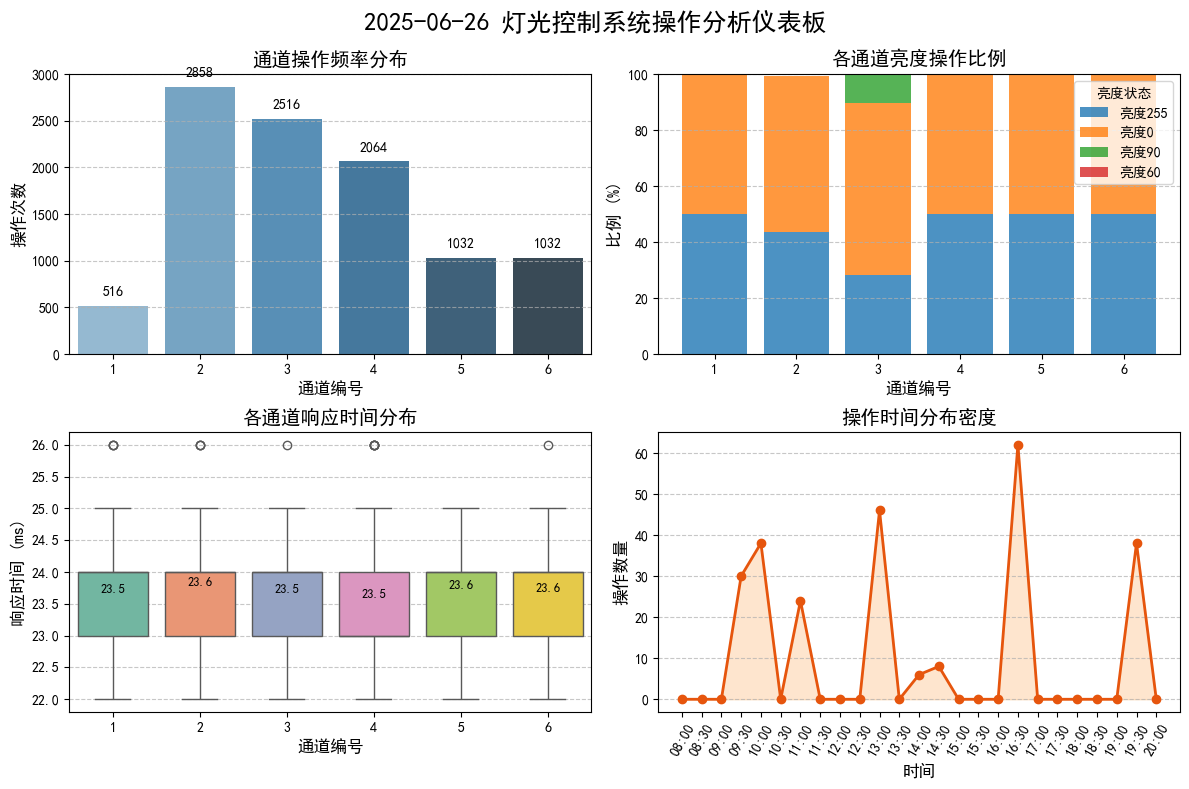

In [25]:
# 1. 通道操作频率分布图
plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, height_ratios=[1, 1])

# 通道操作频率柱状图
plt.subplot(gs[0, 0])
channel_counts = df['通道'].value_counts().sort_index()
ax1 = sns.barplot(x=channel_counts.index, y=channel_counts.values, palette="Blues_d")
plt.title('通道操作频率分布', fontsize=14, fontweight='bold')
plt.xlabel('通道编号', fontsize=12)
plt.ylabel('操作次数', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加数值标签
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# 2. 通道亮度操作比例图
plt.subplot(gs[0, 1])
brightness_counts = df.groupby('通道')['亮度'].value_counts().unstack()
brightness_percent = brightness_counts.div(brightness_counts.sum(axis=1), axis=0) * 100
# 创建堆叠条形图
bottom = np.zeros(6)
for i, state in enumerate(df['亮度'].unique()):
    plt.bar(brightness_percent.index, brightness_percent[state], bottom=bottom, label=f'亮度{state}', alpha=0.8)
    bottom += brightness_percent[state]

plt.title('各通道亮度操作比例', fontsize=14, fontweight='bold')
plt.xlabel('通道编号', fontsize=12)
plt.ylabel('比例 (%)', fontsize=12)
plt.legend(title='亮度状态', loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. 响应时间分布分析
plt.subplot(gs[1, 0])
sns.boxplot(data=df, x='通道', y='设置时间', palette="Set2", showfliers=True)
plt.title('各通道响应时间分布', fontsize=14, fontweight='bold')
plt.xlabel('通道编号', fontsize=12)
plt.ylabel('响应时间 (ms)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加平均值标记
for i in df['通道'].unique():
    mean_value = df[df['通道'] == i]['设置时间'].mean()
    plt.text(i-1, mean_value + 0.1, f'{mean_value:.1f}', ha='center', va='bottom', fontsize=9)

# 4. 时间序列操作密度分析
plt.subplot(gs[1, 1])
df['hour_min'] = df['时间'].dt.strftime('%H:%M')
hourly_ops = df.groupby('hour_min').size()
# 选择代表性的时间点
selected_hours = pd.date_range(f"{filename.replace('_', '-')} 08:00", periods=25, freq='30min').strftime('%H:%M')
hourly_ops = hourly_ops.reindex(selected_hours, fill_value=0)

plt.plot(hourly_ops.index, hourly_ops.values, marker='o', linestyle='-', color='#e6550d', linewidth=2)
plt.fill_between(hourly_ops.index, hourly_ops.values, color='#fdbe85', alpha=0.4)

plt.title('操作时间分布密度', fontsize=14, fontweight='bold')
plt.xlabel('时间', fontsize=12)
plt.ylabel('操作数量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=60)

# 整体布局调整
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(f'{filename.replace("_", "-")} 灯光控制系统操作分析仪表板', fontsize=18, fontweight='bold')
plt.savefig(f'../datas/imgs/lightcontrol/灯光控制系统操作分析仪表板{filename}.png', dpi=300, bbox_inches='tight')

In [26]:
hourly_ops

08:00     0
08:30     0
09:00     0
09:30    30
10:00    38
10:30     0
11:00    24
11:30     0
12:00     0
12:30     0
13:00    46
13:30     0
14:00     6
14:30     8
15:00     0
15:30     0
16:00     0
16:30    62
17:00     0
17:30     0
18:00     0
18:30     0
19:00     0
19:30    38
20:00     0
dtype: int64